In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from math import sqrt
from keras.callbacks import History 
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing import image

def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img

os.chdir('/home/rsk/Documents/Projects/YOLO/25x25/')

X = []

for i in range(8000):
    img = read_img(str(i)+'.png',(25,25))
    X.append(img)

In [3]:


truth = pd.read_csv('25x25_truth.csv')
y = np.array(truth)
y = np.array(y[:,1:])


X= np.array(X)
y = np.array(y)


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size=25


trainX = X[:7000,:,:,:]
trainy = y[:7000,:]

testX = X[7000:,:,:,:]
testy = y[7000:,:]

train_generator = train_datagen.flow(x=trainX,y=trainy,batch_size=batch_size)
test_generator = test_datagen.flow(x=testX,y=testy,batch_size=batch_size)

In [4]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou


def getIoU(model,testData,testTruth,rescale=True):
    
    sample = testData
    if rescale==True:
        sample = testData/255.
    pred = model.predict(sample)
    
    
    testTruth = [[i[0],i[1],i[0]+i[2],i[1]+i[3]] for i in testTruth]
    pred = [[i[0],i[1],i[0]+i[2],i[1]+i[3]] for i in pred]
    
    IoUSum = 0.0
    for i in range(len(testTruth)):
        IoUSum += bb_intersection_over_union(testTruth[i],pred[i])
    
    meanIoU = IoUSum/len(testTruth)
    
    return(meanIoU)

def getMSE(model,testData,testTruth,rescale=True):
    
    sample = testData
    if rescale==True:
        sample = sample/255.
    pred = model.predict(sample)
    
    MSESum = 0.0
    for i in range(len(testTruth)):
        a = np.array(testTruth[i])
        b = pred[i]
        MSESum += sqrt(np.sum((a-b)**2))
    
    meanMSE = MSESum/len(testTruth)
    
    return(meanMSE)
   

In [5]:
import keras.backend as K

def iou(y_true,y_pred):
    a=y_true[0]
    b=y_pred[0]
    
    
    xa = K.maximum(a[0],b[0])
    ya = K.maximum(a[1],b[1])
    xb = K.minimum(a[0]+a[2],b[0]+b[2])
    yb = K.minimum(a[1]+a[3],b[1]+b[3])
    
    
    interArea = K.maximum(K.constant(0.0), xb -xa + K.constant(1.0))*K.maximum(K.constant(0.0), yb -ya + K.constant(1.0))
    
    boxAarea= (a[2]  + 1) * (a[3]  + 1)
    boxBarea= (b[2]  + 1) * (b[3]  + 1)
    
    iou = interArea / (boxAarea + boxBarea - interArea)
    
    return(iou)

def iou2(y_true,y_pred):
    a=y_true
    b=y_pred
    
    xa = K.maximum(a[:,0],b[:,0])
    ya = K.maximum(a[:,1],b[:,1])
    xb = K.minimum(a[:,0]+a[:,2],b[:,0]+b[:,2])
    yb = K.minimum(a[:,1]+a[:,3],b[:,1]+b[:,3])
    
    
    interArea = K.maximum(K.constant(0.0), xb -xa + K.constant(1.0))*K.maximum(K.constant(0.0), yb -ya + K.constant(1.0))
    
    boxAarea= (a[:,2]  + 1) * (a[:,3]  + 1)
    boxBarea= (b[:,2]  + 1) * (b[:,3]  + 1)
    
    iou = interArea / (boxAarea + boxBarea - interArea)
    return(-1*K.mean(iou))
    

In [6]:
def cleanFolder(buildNo,keep=5):
    
    os.chdir('./Models_IOU/')
    fileList = os.listdir('./')
    
    selectFileList = []
    for filename in fileList:
        if str(buildNo) in filename.split("_"):
            selectFileList.append(filename)
            
    a = []
    for i in selectFileList:
        val = float(i[:-5].split("_")[3])
        a.append([val,i])
        
    a = sorted(a,key=lambda x : x[0])
    
    keep = min(keep,len(a))
    
    keepList = [i[1] for i in a[:keep]]
    dropList = [i[1] for i in a[keep:]]
    
    for filename in dropList:
        os.remove(filename)
    print(keepList)
    return(keepList)
 

In [7]:
def runModel(model,epochs,build=1,optimizer = 'adagrad',keep=5):
    
        os.chdir('/home/rsk/Documents/Projects/YOLO/BoundingBox/')
    
        model.compile(loss=iou2,optimizer=optimizer,metrics=[iou2,'mse'])
        hist = History()
        checkPoint = ModelCheckpoint(filepath='./Models_IOU/model_'+str(build)+'_{epoch:02d}_{val_loss:.2f}.hdf5',verbose=1,save_best_only=True,mode=min)
    
        model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,callbacks = [hist,checkPoint],verbose=0)
        
        keepList = cleanFolder(build,keep=keep)
       
        for filename in keepList:
            model = load_model(filename, custom_objects={'iou2': iou2})
            epoch = filename.split("_")[2]
            mse = filename.split("_")[3]
            IoU = round(getIoU(model,testX,testy),3)
            print("Epoch : {} MSE : {} IoU : {}".format(epoch,mse,IoU))
        
        del model
        gc.collect()
            
        

In [8]:
os.chdir('/home/rsk/Documents/Projects/YOLO/BoundingBox/')

### Model Run Iterations

In [17]:


#this with adagrad gives 0.03

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(25,25,3), data_format='channels_last',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))


In [ ]:
runModel(model,epochs=10,build=1,optimizer='adadelta')


Epoch 00001: val_loss improved from inf to -0.03495, saving model to ./Models_IOU/model_1_01_-0.03.hdf5

Epoch 00002: val_loss improved from -0.03495 to -0.21190, saving model to ./Models_IOU/model_1_02_-0.21.hdf5

Epoch 00003: val_loss improved from -0.21190 to -0.22720, saving model to ./Models_IOU/model_1_03_-0.23.hdf5

Epoch 00004: val_loss improved from -0.22720 to -0.31904, saving model to ./Models_IOU/model_1_04_-0.32.hdf5

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from -0.31904 to -0.47258, saving model to ./Models_IOU/model_1_09_-0.47.hdf5

Epoch 00010: val_loss did not improve
['model_1_87_-0.78.hdf5', 'model_1_62_-0.75.hdf5', 'model_1_43_-0.71.hdf5', 'model_1_38_-0.71.hdf5', 'model_1_30_-0.70.hdf5']
Epoch : 87 MSE : -0.78.hdf5 IoU : 0.781


In [110]:
runModel(model,epochs=100,build=1)


Epoch 00001: val_loss improved from inf to 96.43899, saving model to ./Models/model_1_01_96.44.hdf5

Epoch 00002: val_loss improved from 96.43899 to 44.77222, saving model to ./Models/model_1_02_44.77.hdf5

Epoch 00003: val_loss improved from 44.77222 to 4.61674, saving model to ./Models/model_1_03_4.62.hdf5

Epoch 00004: val_loss improved from 4.61674 to 0.91394, saving model to ./Models/model_1_04_0.91.hdf5

Epoch 00005: val_loss improved from 0.91394 to 0.81997, saving model to ./Models/model_1_05_0.82.hdf5

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss improved from 0.81997 to 0.79646, saving model to ./Models/model_1_07_0.80.hdf5

Epoch 00008: val_loss improved from 0.79646 to 0.67021, saving model to ./Models/model_1_08_0.67.hdf5

Epoch 00009: val_loss improved from 0.67021 to 0.66241, saving model to ./Models/model_1_09_0.66.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss improved from 0.66241 to 0.55035, 


Epoch 00184: val_loss did not improve

Epoch 00185: val_loss did not improve

Epoch 00186: val_loss did not improve

Epoch 00187: val_loss did not improve

Epoch 00188: val_loss did not improve

Epoch 00189: val_loss did not improve

Epoch 00190: val_loss did not improve

Epoch 00191: val_loss did not improve

Epoch 00192: val_loss did not improve

Epoch 00193: val_loss did not improve

Epoch 00194: val_loss did not improve

Epoch 00195: val_loss did not improve

Epoch 00196: val_loss did not improve

Epoch 00197: val_loss did not improve

Epoch 00198: val_loss did not improve

Epoch 00199: val_loss did not improve

Epoch 00200: val_loss did not improve
Epoch : 115 MSE : 0.43.hdf5 IoU : 0.757
Epoch : 161 MSE : 0.43.hdf5 IoU : 0.764
Epoch : 94 MSE : 0.46.hdf5 IoU : 0.754
Epoch : 60 MSE : 0.47.hdf5 IoU : 0.739
Epoch : 39 MSE : 0.51.hdf5 IoU : 0.723


In [19]:
# With 7000 samples to train
runModel(model,epochs=100,build=1,optimizer='adadelta')


Epoch 00001: val_loss improved from inf to 6.04745, saving model to ./Models/model_1_01_6.05.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss improved from 6.04745 to 3.61774, saving model to ./Models/model_1_03_3.62.hdf5

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss improved from 3.61774 to 1.03209, saving model to ./Models/model_1_05_1.03.hdf5

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss improved from 1.03209 to 0.41547, saving model to ./Models/model_1_13_0.42.hdf5

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss improved from 0.41547 to 0.32324, saving model to ./Models/model_1_17_0.32.hdf5

Epoch 00018: val_los

#### Build 2

In [15]:


model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(25,25,3), data_format='channels_last',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))


In [16]:
runModel(model,epochs=20,build=2)


Epoch 00001: val_loss improved from inf to 0.00000, saving model to ./Models_IOU/model_2_01_0.00.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve


KeyboardInterrupt: 

#### Build 3

In [20]:
import gc
del model
gc.collect()

730

In [9]:


model = Sequential()
model.add(BatchNormalization(input_shape=(25,25,3)))
model.add(Conv2D(64, (3,3),activation='relu', data_format='channels_last'))

model.add(Dropout(0.3))
model.add(Conv2D(32, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))


In [13]:
runModel(model,epochs=50,build=3)


Epoch 00001: val_loss improved from inf to 0.00000, saving model to ./Models_IOU/model_3_01_0.00.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss did not improve

Epoch 00018: val_loss did not improve

Epoch 00019: val_loss did not improve

Epoch 00020: val_loss did not improve

Epoch 00021: val_loss did not improve

Epoch 00022: val_loss did not improve

Epoch 00023: val_loss did not improve

Epoch 00024: val_loss did not improve


In [11]:
runModel(model,epochs=100,build=3,optimizer='adadelta')


Epoch 00001: val_loss improved from inf to -0.81876, saving model to ./Models_IOU/model_3_01_-0.82.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss improved from -0.81876 to -0.83421, saving model to ./Models_IOU/model_3_11_-0.83.hdf5

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss did not improve

Epoch 00018: val_loss did not improve

Epoch 00019: val_loss did not improve

Epoch 00020: val_loss did not improve

Epoch 00021: val_loss did not improve

Epoch 00022: val_loss did not improve

Epoc

In [22]:
#With 7000 training samples
runModel(model,epochs=150,build=3,optimizer='adadelta')


Epoch 00001: val_loss improved from inf to 6.04701, saving model to ./Models/model_3_01_6.05.hdf5

Epoch 00002: val_loss improved from 6.04701 to 1.76040, saving model to ./Models/model_3_02_1.76.hdf5

Epoch 00003: val_loss improved from 1.76040 to 0.51387, saving model to ./Models/model_3_03_0.51.hdf5

Epoch 00004: val_loss improved from 0.51387 to 0.42953, saving model to ./Models/model_3_04_0.43.hdf5

Epoch 00005: val_loss improved from 0.42953 to 0.38328, saving model to ./Models/model_3_05_0.38.hdf5

Epoch 00006: val_loss improved from 0.38328 to 0.29723, saving model to ./Models/model_3_06_0.30.hdf5

Epoch 00007: val_loss improved from 0.29723 to 0.29074, saving model to ./Models/model_3_07_0.29.hdf5

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 000

#### Build 4

In [7]:


#this with adagrad gives 0.03

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(25,25,3), data_format='channels_last',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))


In [8]:
runModel(model,epochs=200,build=4)

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:408: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)



Epoch 00001: val_loss improved from inf to 21.44710, saving model to ./Models/model_4_01_21.45.hdf5

Epoch 00002: val_loss improved from 21.44710 to 19.53970, saving model to ./Models/model_4_02_19.54.hdf5

Epoch 00003: val_loss improved from 19.53970 to 15.99952, saving model to ./Models/model_4_03_16.00.hdf5

Epoch 00004: val_loss improved from 15.99952 to 14.32271, saving model to ./Models/model_4_04_14.32.hdf5

Epoch 00005: val_loss improved from 14.32271 to 12.88201, saving model to ./Models/model_4_05_12.88.hdf5

Epoch 00006: val_loss improved from 12.88201 to 12.21619, saving model to ./Models/model_4_06_12.22.hdf5

Epoch 00007: val_loss improved from 12.21619 to 11.81272, saving model to ./Models/model_4_07_11.81.hdf5

Epoch 00008: val_loss improved from 11.81272 to 10.97164, saving model to ./Models/model_4_08_10.97.hdf5

Epoch 00009: val_loss improved from 10.97164 to 9.94475, saving model to ./Models/model_4_09_9.94.hdf5

Epoch 00010: val_loss improved from 9.94475 to 9.674


Epoch 00140: val_loss did not improve

Epoch 00141: val_loss did not improve

Epoch 00142: val_loss did not improve

Epoch 00143: val_loss did not improve

Epoch 00144: val_loss did not improve

Epoch 00145: val_loss did not improve

Epoch 00146: val_loss did not improve

Epoch 00147: val_loss did not improve

Epoch 00148: val_loss did not improve

Epoch 00149: val_loss did not improve

Epoch 00150: val_loss did not improve

Epoch 00151: val_loss did not improve

Epoch 00152: val_loss did not improve

Epoch 00153: val_loss did not improve

Epoch 00154: val_loss did not improve

Epoch 00155: val_loss did not improve

Epoch 00156: val_loss did not improve

Epoch 00157: val_loss did not improve

Epoch 00158: val_loss did not improve

Epoch 00159: val_loss did not improve

Epoch 00160: val_loss did not improve

Epoch 00161: val_loss did not improve

Epoch 00162: val_loss did not improve

Epoch 00163: val_loss did not improve

Epoch 00164: val_loss did not improve

Epoch 00165: val_loss di

In [24]:
import gc
del model
gc.collect()

996

#### Build 5

In [16]:


#this with adagrad gives 0.03

model = Sequential()
model.add(Conv2D(128, (3,3), input_shape=(25,25,3), data_format='channels_last',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))


In [18]:
runModel(model,epochs=250,build=5)


Epoch 00001: val_loss improved from inf to 1422.74748, saving model to ./Models/model_5_01_1422.75.hdf5

Epoch 00002: val_loss improved from 1422.74748 to 139.53004, saving model to ./Models/model_5_02_139.53.hdf5

Epoch 00003: val_loss improved from 139.53004 to 57.09646, saving model to ./Models/model_5_03_57.10.hdf5

Epoch 00004: val_loss improved from 57.09646 to 46.56733, saving model to ./Models/model_5_04_46.57.hdf5

Epoch 00005: val_loss improved from 46.56733 to 26.57596, saving model to ./Models/model_5_05_26.58.hdf5

Epoch 00006: val_loss improved from 26.57596 to 6.04373, saving model to ./Models/model_5_06_6.04.hdf5

Epoch 00007: val_loss improved from 6.04373 to 2.75538, saving model to ./Models/model_5_07_2.76.hdf5

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 2.75538 to 2.17378, saving model to ./Models/model_5_09_2.17.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve



Epoch 00196: val_loss did not improve

Epoch 00197: val_loss did not improve

Epoch 00198: val_loss did not improve

Epoch 00199: val_loss did not improve

Epoch 00200: val_loss did not improve

Epoch 00201: val_loss did not improve

Epoch 00202: val_loss did not improve

Epoch 00203: val_loss did not improve

Epoch 00204: val_loss did not improve

Epoch 00205: val_loss did not improve

Epoch 00206: val_loss did not improve

Epoch 00207: val_loss did not improve

Epoch 00208: val_loss did not improve

Epoch 00209: val_loss did not improve

Epoch 00210: val_loss did not improve

Epoch 00211: val_loss did not improve

Epoch 00212: val_loss did not improve

Epoch 00213: val_loss did not improve

Epoch 00214: val_loss did not improve

Epoch 00215: val_loss did not improve

Epoch 00216: val_loss did not improve

Epoch 00217: val_loss did not improve

Epoch 00218: val_loss did not improve

Epoch 00219: val_loss did not improve

Epoch 00220: val_loss did not improve

Epoch 00221: val_loss di

#### Build 6

In [22]:
model = Sequential()
model.add(BatchNormalization(input_shape=(25,25,3)))
model.add(Conv2D(256, (3,3),activation='relu', data_format='channels_last'))

model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))

In [23]:
runModel(model,epochs=150,build=6)


Epoch 00001: val_loss improved from inf to 14.42987, saving model to ./Models/model_6_01_14.43.hdf5

Epoch 00002: val_loss improved from 14.42987 to 11.06086, saving model to ./Models/model_6_02_11.06.hdf5

Epoch 00003: val_loss improved from 11.06086 to 8.85930, saving model to ./Models/model_6_03_8.86.hdf5

Epoch 00004: val_loss improved from 8.85930 to 6.77302, saving model to ./Models/model_6_04_6.77.hdf5

Epoch 00005: val_loss improved from 6.77302 to 5.44820, saving model to ./Models/model_6_05_5.45.hdf5

Epoch 00006: val_loss improved from 5.44820 to 4.67691, saving model to ./Models/model_6_06_4.68.hdf5

Epoch 00007: val_loss improved from 4.67691 to 3.94729, saving model to ./Models/model_6_07_3.95.hdf5

Epoch 00008: val_loss improved from 3.94729 to 3.49877, saving model to ./Models/model_6_08_3.50.hdf5

Epoch 00009: val_loss improved from 3.49877 to 3.16207, saving model to ./Models/model_6_09_3.16.hdf5

Epoch 00010: val_loss improved from 3.16207 to 2.73681, saving model t


Epoch 00119: val_loss did not improve

Epoch 00120: val_loss did not improve

Epoch 00121: val_loss improved from 0.52990 to 0.52648, saving model to ./Models/model_6_121_0.53.hdf5

Epoch 00122: val_loss did not improve

Epoch 00123: val_loss did not improve

Epoch 00124: val_loss did not improve

Epoch 00125: val_loss did not improve

Epoch 00126: val_loss improved from 0.52648 to 0.52106, saving model to ./Models/model_6_126_0.52.hdf5

Epoch 00127: val_loss did not improve

Epoch 00128: val_loss did not improve

Epoch 00129: val_loss did not improve

Epoch 00130: val_loss improved from 0.52106 to 0.52054, saving model to ./Models/model_6_130_0.52.hdf5

Epoch 00131: val_loss did not improve

Epoch 00132: val_loss improved from 0.52054 to 0.51989, saving model to ./Models/model_6_132_0.52.hdf5

Epoch 00133: val_loss did not improve

Epoch 00134: val_loss did not improve

Epoch 00135: val_loss did not improve

Epoch 00136: val_loss improved from 0.51989 to 0.50149, saving model to ./Mo

#### Build 7

In [8]:


#this with adagrad gives 0.03

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(25,25,3), data_format='channels_last',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(32, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))


In [9]:
runModel(model,epochs=100,build=7,optimizer='adam')

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:408: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)



Epoch 00001: val_loss improved from inf to 39.06089, saving model to ./Models/model_7_01_39.06.hdf5

Epoch 00002: val_loss improved from 39.06089 to 34.09735, saving model to ./Models/model_7_02_34.10.hdf5

Epoch 00003: val_loss did not improve

Epoch 00004: val_loss improved from 34.09735 to 5.31322, saving model to ./Models/model_7_04_5.31.hdf5

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss improved from 5.31322 to 2.01356, saving model to ./Models/model_7_08_2.01.hdf5

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss improved from 2.01356 to 1.78112, saving model to ./Models/model_7_16_1.78.hdf5

Epoch 00017: val_loss did not improve

Epoch 00018: v

In [10]:
runModel(model,epochs=100,build=7,optimizer='adadelta')


Epoch 00001: val_loss improved from inf to 1.33717, saving model to ./Models/model_7_01_1.34.hdf5

Epoch 00002: val_loss improved from 1.33717 to 0.88333, saving model to ./Models/model_7_02_0.88.hdf5

Epoch 00003: val_loss improved from 0.88333 to 0.43694, saving model to ./Models/model_7_03_0.44.hdf5

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss did not improve

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss improved from 0.43694 to 0.43051, saving model to ./Models/model_7_14_0.43.hdf5

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss did not improve

Epoch 00018: val_loss did not improve

Epoch 00019: val_loss did not improve

Epoch 

#### Build 8

### Testing

In [16]:
model = load_model('./model_3_83_0.20.hdf5')

In [23]:
model1 = load_model('./model_3_142_0.03.hdf5')

In [25]:
def testSample(obs,modelList):
    
    if obs>=len(testX):
        print("Out of bounds")
        
    sample = testX[obs]
    
    sample = sample.reshape((1,25,25,3))
    sample = sample/255.
    truth = [testy[obs]]
    
    IoU1 = getIoU(modelList[0][0], sample, truth,rescale=False)
    IoU2 = getIoU(modelList[1][0], sample, truth,rescale=False)
    
    pred1 = modelList[0][0].predict(sample)
    pred2 = modelList[1][0].predict(sample)
    
    factor=0.2
    matplotlib.rcParams['figure.figsize'] = [40*factor,75*factor]
    
    
    fig,ax = plt.subplots(1)
    
    ax.imshow(sample[0,:,:,:])

   
    rect1 = Rectangle((pred1[0][1]-0.5,pred1[0][0]-0.5),pred1[0][3], pred1[0][2],fill=False,edgecolor=modelList[0][1],
                     linewidth=2)
    rect2 = Rectangle((pred2[0][1]-0.5,pred2[0][0]-0.5),pred2[0][3], pred2[0][2],fill=False,edgecolor=modelList[1][1],
                     linewidth=2)
    
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    
#     ax.scatter(pred1[0][1]-0.5,pred1[0][0]-0.5, s=55, c=modelList[0][1], marker='o')
#     ax.scatter(pred1[0][1]-0.5+pred1[0][3],pred1[0][0]-0.5+pred1[0][2], s=55, c=modelList[0][1], marker='o')
    
#     ax.scatter(pred2[0][1]-0.5,pred2[0][0]-0.5, s=55, c=modelList[1][1], marker='o')
#     ax.scatter(pred2[0][1]-0.5+pred2[0][3],pred2[0][0]-0.5+pred2[0][2], s=55, c=modelList[1][1], marker='o')
    
    print("Truth : {}".format(truth[0]))
    print("Pred1 : {}".format(pred1))
    print("Pred2 : {}".format(pred2))
    
    print("IoU1 : {} IoU2 : {}".format(IoU1,IoU2))
    
    plt.show()
    

Truth : [13 18  3  4]
Pred1 : [[13.178262  18.13037    3.0815568  4.1109905]]
Pred2 : [[13.012241  17.963167   3.0611875  3.974077 ]]
IoU1 : 0.836411897082 IoU2 : 0.959848945306


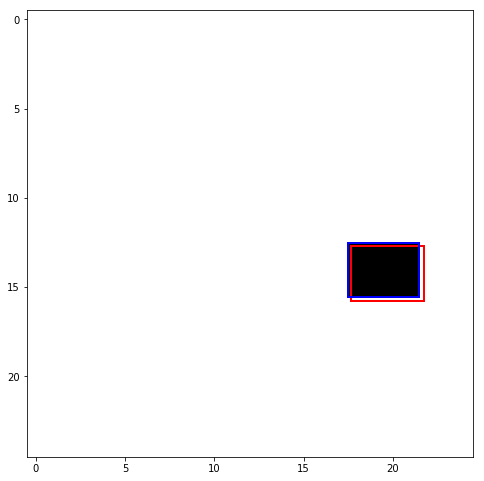

In [31]:
testSample(102,[[model,'red'],[model1,'blue']])

In [55]:
def testSamples(obs,modelList):
    
    if obs>=len(testX):
        print("Out of bounds")
        
    sample = testX[obs:(obs+15)]
    sample = sample/255.
    truth = testy[obs:(obs+15)]
    
#     sample = testX
#     sample = sample/255.
#     truth = testy
    
    preds=[]
    for i in range(len(modelList)):
        pred = modelList[i][0].predict(sample)
        preds.append(pred)
        
    IoU1 = getIoU(modelList[0][0], sample, truth,rescale=False)
    IoU2 = getIoU(modelList[1][0], sample, truth,rescale=False)
    
#     pred = model.predict(sample.reshape((-1,25,25,3)))

    
    factor=0.2
    matplotlib.rcParams['figure.figsize'] = [80*factor,150*factor]



    for i in range(15):
        plt.subplot(5,3,i+1)

        plt.imshow(sample[i])
        
        for j in range(len(modelList)):
            plt.scatter(preds[j][i][1]-0.5,preds[j][i][0]-0.5, s=55, c=modelList[j][1], marker='o')
            plt.scatter(preds[j][i][1]-0.5+preds[j][i][3],preds[j][i][0]-0.5+preds[j][i][2], s=55, c=modelList[j][1], marker='o')
        
    print("IoU1 : {} IoU2 : {}".format(IoU1,IoU2))
    plt.show()
    
    
    
    


IoU1 : 0.824181912192 IoU2 : 0.620529050468


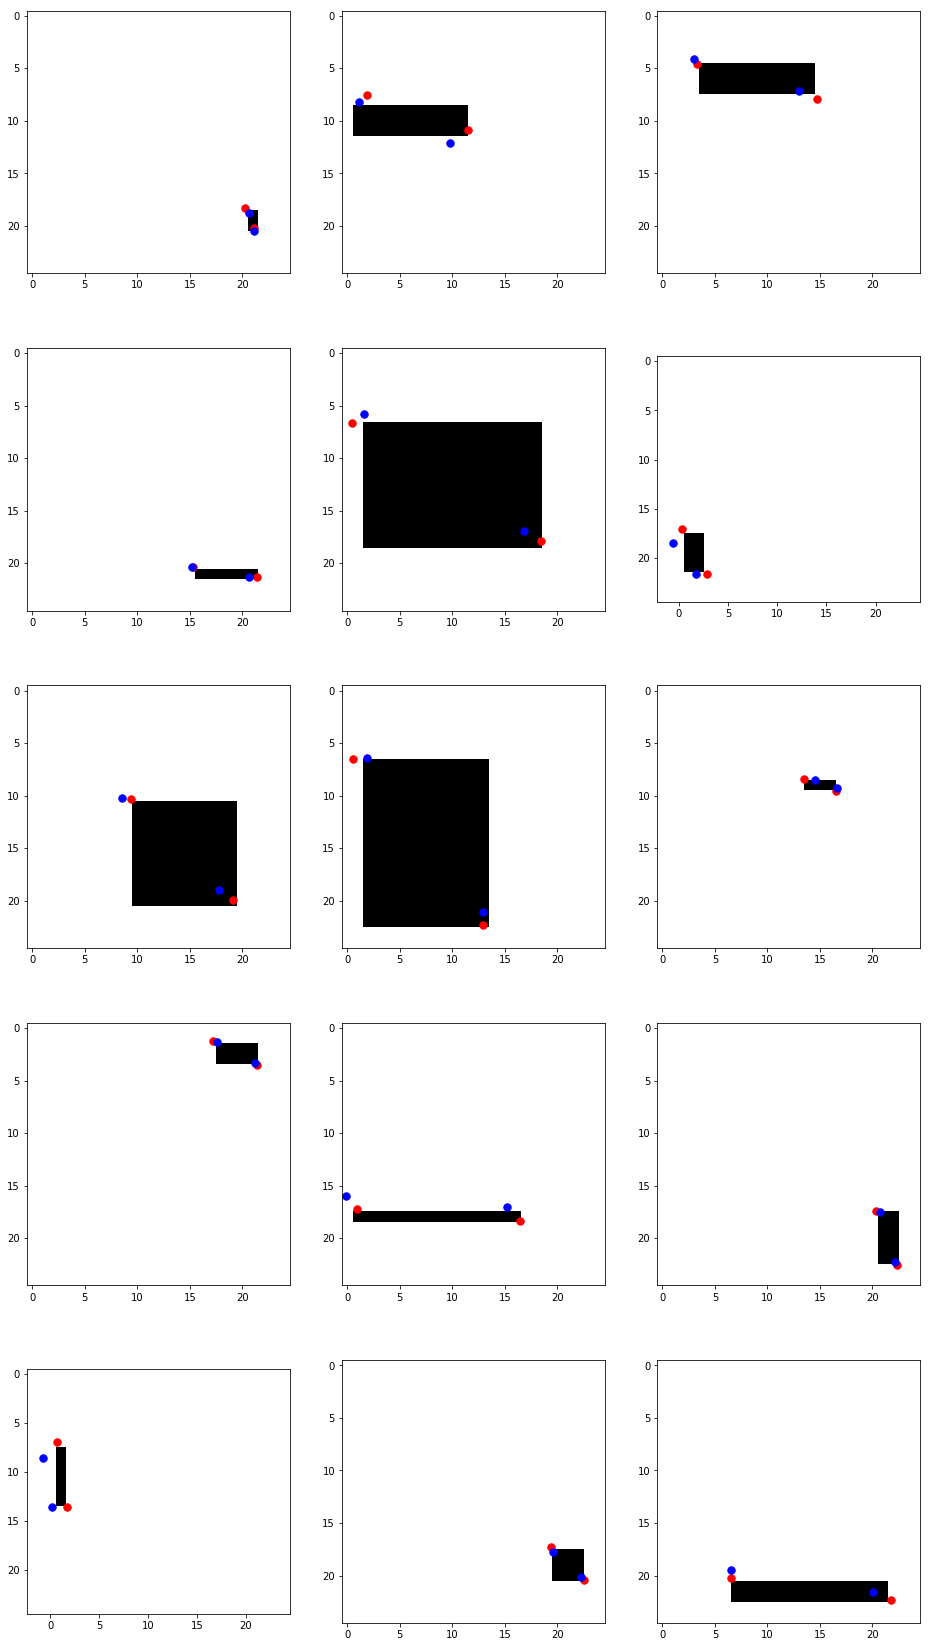

In [56]:

testSamples(23,[[model,'red'],[model1,'blue']])